# DeepArk Supplementary Figure 2 Notebook

## Setup

In [1]:
import copy

# genomics
import pyfaidx
import selene_sdk
import selene_sdk.interpret

# Stats etc.
import numpy
import pandas
import h5py

# Viz
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook

# Configure pandas printing.
pandas.options.display.max_rows = 12

/data/home/ecofer/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Load metadata

In [2]:
# Read in metadata.
feat_df = pandas.read_csv("../DeepArk/data/caenorhabditis_elegans.tsv", sep="\t")
feat_df.drop(["test_auc_roc", "test_auc_prc"], axis=1, inplace=True)

# Ensure proper ordering.
with open("../train/distinct_features.caenorhabditis_elegans.txt", "r") as read_file:
    cur_accessions = [x.strip() for x in read_file.readlines()]
feat_df.set_index("accession", inplace=True)
feat_df = feat_df.loc[cur_accessions, :]
feat_df = feat_df.reset_index()
print("Finished.")

Finished.


## Load data

### Load FIMO hits
- Run `dcc/get_motif_hits.sh` first

In [3]:
motif_hit_df = pandas.read_csv("../DCC/outputs/fimo_out/fimo.tsv", sep="\t", comment="#")
display(motif_hit_df)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,REX,rex,chrX:11092095-11096190,2028,2039,-,21.55060,3.110000e-08,0.000763,TCGCGCAGGGAG
1,REX,rex,chrX:14523895-14527990,2003,2014,-,20.15730,1.310000e-07,0.001070,TCGCGCAGGGAC
2,REX,rex,chrX:11092095-11096190,2129,2140,-,20.15730,1.310000e-07,0.001070,TCGCGCAGGGAC
3,REX,rex,chrX:14523895-14527990,2028,2039,+,19.57300,2.380000e-07,0.001460,TCGCGAAGGGAC
4,REX,rex,chrX:6294495-6298590,2079,2090,+,17.88760,7.760000e-07,0.003800,TCGCGCAGGGAA
5,REX,rex,chrX:6294495-6298590,2051,2062,+,16.82020,1.650000e-06,0.006730,TGGCGCAGGGGG
6,REX,rex,chrX:6294495-6298590,2014,2025,+,14.59550,4.900000e-06,0.017100,AAGCGAAGGGAC
7,REX,rex,chrX:11092095-11096190,2145,2156,-,7.19101,6.110000e-05,0.187000,TTGCGAAGGGAA
8,REX,rex,chrX:11092095-11096190,3535,3546,-,6.65169,7.430000e-05,0.202000,TGGAGGAGAGAG
9,REX,rex,chrX:11092095-11096190,2461,2472,+,6.32584,8.280000e-05,0.203000,tcgcggaggttg


### Load ISM results
- The following uses the data in `DCC/chrX:6294495-6298590.tsv` and so on. Uncomment the commented block to use your own inputs from reproducing the _in silico_ saturated mutagenesis of the top predicted DCC sites.

In [4]:
# If you plan to use the included data, use the following code:
top_sites = ["chrX:6294495-6298590", "chrX:14523895-14527990", "chrX:11092095-11096190"]
dfs = list()
refs = list()
for x in top_sites:
    i_f = "../DCC/{}.tsv".format(x)
    with open(i_f, "r") as read_file:
        for line in read_file:
            break
    assert line.startswith("#")
    refs.append(float(line.strip().split()[-1]))
    df = pandas.read_csv(i_f, sep="\t", comment="#")
    df.columns = ["chrom", "pos", "ref", "alt", "SRX2228883"]
    dfs.append(df)
    
# # If you plan to use your own data from re-running the DeepArk predictions, uncomment the following:
# idx = numpy.where(numpy.array(cur_accessions) == "SRX2228883")[0][0]
# top_sites = ["chrX:6294495-6298590", "chrX:14523895-14527990", "chrX:11092095-11096190"]
# dfs = list()
# refs = list()
# for x in top_sites:
#     h5 = h5py.File("../DCC/outputs/{}_diffs.h5".format(x), "r")
#     m = h5["data"][()]
#     h5.close()
#     df = pandas.read_csv("../DCC/outputs/{}_row_labels.txt".format(x), sep="\t")
#     df.columns = ["pos", "ref", "alt"]
#     df["chrom"] = "chrX"
#     df["pos"] = df.pos + int(x.split(":")[1].split("-")[0])
#     df = df[["chrom", "pos", "ref", "alt"]]
#     df["SRX2228883"] = m[:, idx]
#     h5 = h5py.File("../DCC/outputs/{}_ref_predictions.h5".format(x), "r")
#     refs.append(h5["data"][0, idx])
#     h5.close()
#     dfs.append(df)

In [5]:
# Load the reference sequences to make masks with.
ref_seqs = list()
ref_seq_masks = list()
fa = pyfaidx.Fasta("../DCC/top_sites.fa")
for x in top_sites:
    ref_seqs.append(str(fa[x][:].seq).upper())
    ref_seq_masks.append(selene_sdk.sequences.Genome.sequence_to_encoding(ref_seqs[-1]))
print("Finished.")

Finished.


## Configure plots

In [6]:
def reset_plot_config():
    seaborn.set()
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    d = {"lines.linewidth": 0.4,
        "axes.linewidth": 0.4,
        "ytick.major.width": 0.4,
        "ytick.minor.width": 0.4,
        "xtick.major.width": 0.4,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "ytick.minor.size": 1.6,
        "ytick.major.pad": 1,
        "xtick.major.pad": 1}

    for k, v in d.items():
        matplotlib.rcParams[k] = v

    matplotlib.rcParams["figure.dpi"] = 300
    matplotlib.rcParams["axes.facecolor"] = "none"
    matplotlib.rcParams["figure.facecolor"] = "none"
    matplotlib.rcParams["xtick.labelsize"] = 6
    matplotlib.rcParams["ytick.labelsize"] = 6
    matplotlib.rcParams["axes.labelsize"] = 6
    matplotlib.rcParams['axes.titlesize'] = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['axes.titlepad'] = 4
    matplotlib.rcParams['axes.ymargin'] = 0
    matplotlib.rcParams['axes.xmargin'] = 0
    for x in ["left", "right", "top", "bottom"]:
        matplotlib.rcParams["figure.subplot.{}".format(x)] = 0.08 if x in {"left",  "bottom"} else 0.99
    matplotlib.rcParams["legend.fancybox"] = False
    
    # Custome legend settings:    
    d = {"legend.borderpad" : 0.4,  
        "legend.labelspacing" : 0.0,  
        "legend.handlelength" : 2.0,  
        "legend.handleheight" : 0.7,
        "legend.handletextpad" : 0.,
        "legend.borderaxespad" : 0.4,
        "legend.fontsize": 6,
        "legend.borderpad": 0.4}

    #legend.columnspacing}
    for k, v in d.items():
        matplotlib.rcParams[k] = v
        
reset_plot_config()

palette = ["#56b4e9", "#e9566b","#00d198", "#e9d556"]

matplotlib.rc('font', size=6)

## Large heatmaps

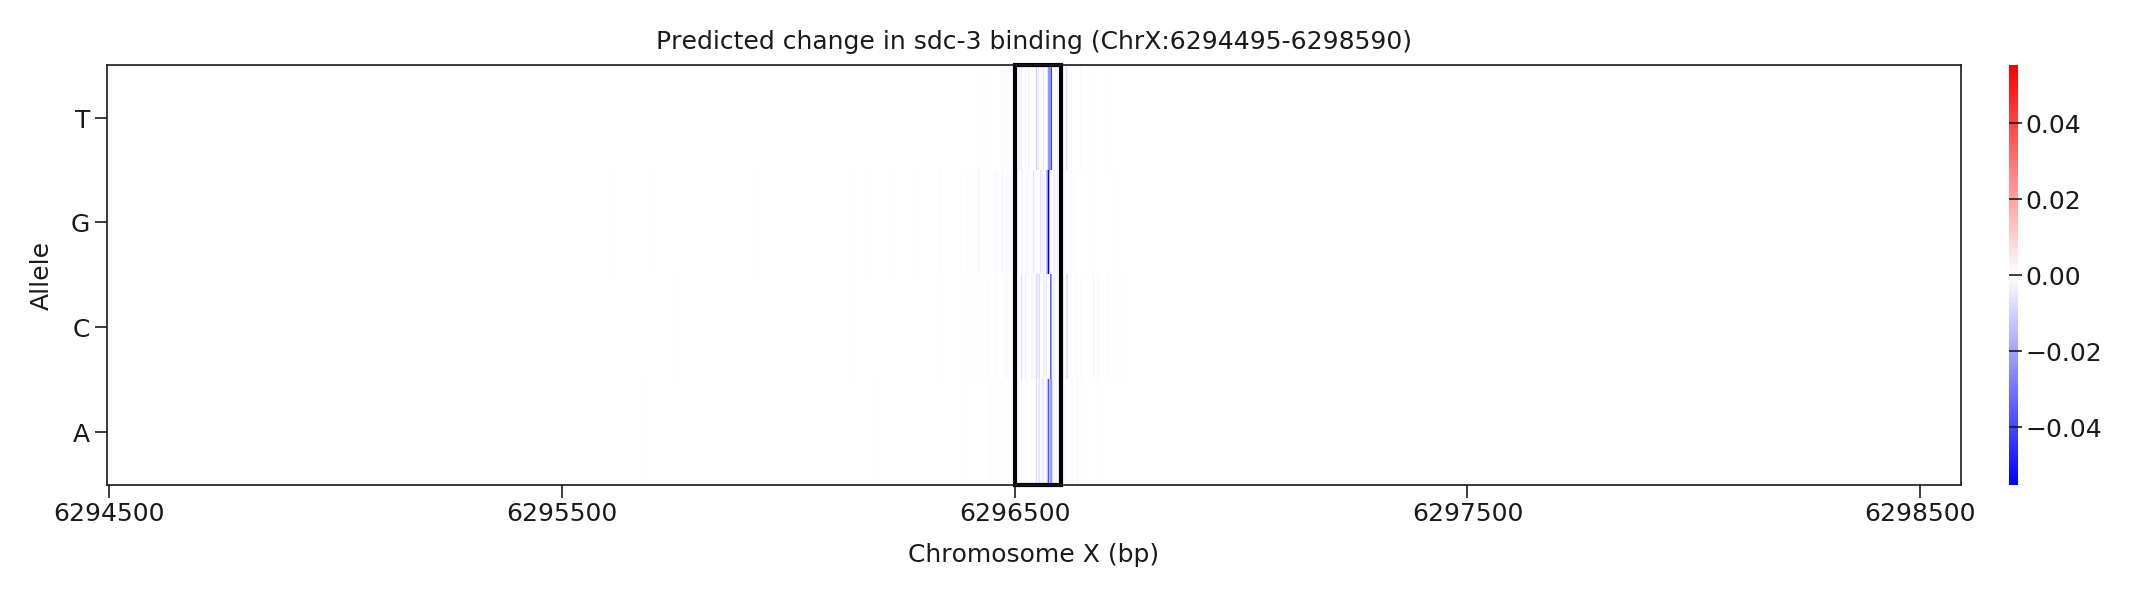

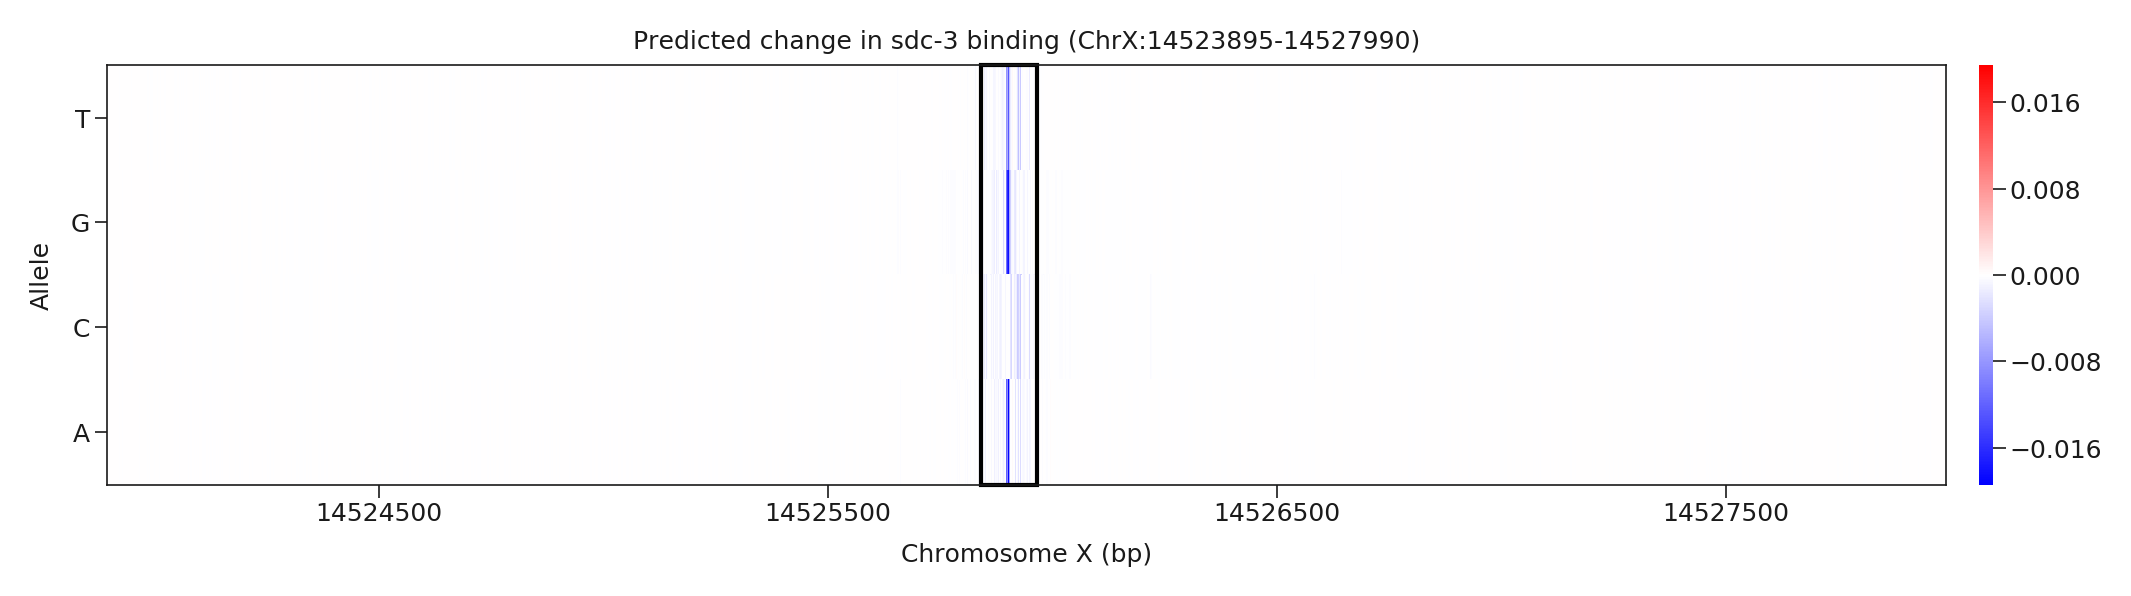

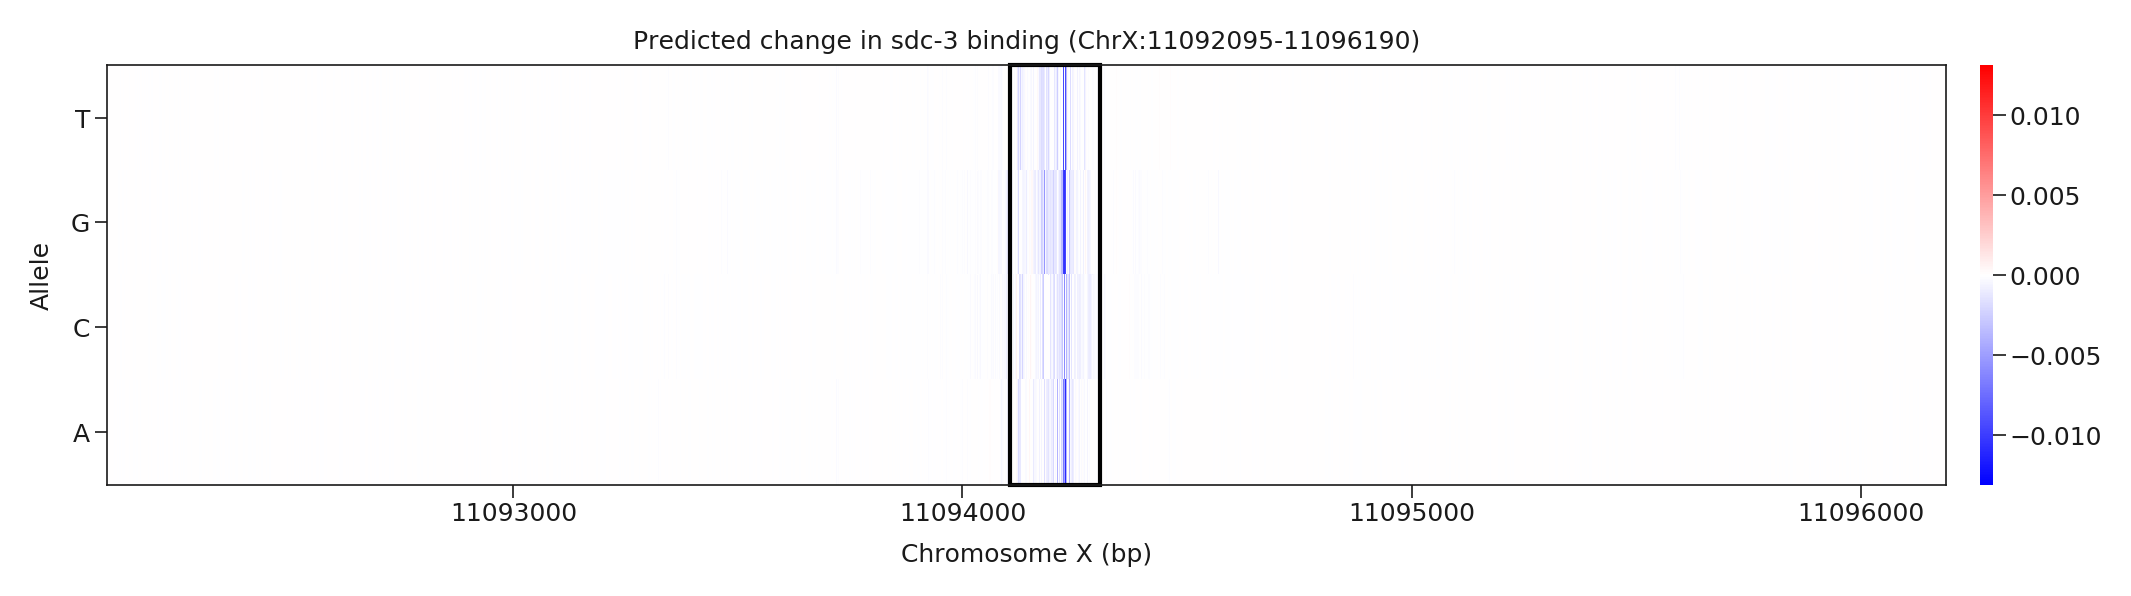

In [7]:
fmt_loci = lambda x: x[0].upper() + x[1:]
acc = "SRX2228883"
for i in range(len(top_sites)):
    # Configure plot.
    fig = plt.figure(facecolor='w', edgecolor='k', figsize=(18/2.54, 5/2.54))
    nrow = 7
    ncol = 41
    ax1 = plt.subplot2grid((nrow, ncol), (0, 0), colspan=ncol-1, rowspan=nrow)
    ax2 = plt.subplot2grid((nrow, ncol), (0, ncol-1), colspan=1, rowspan=nrow)
    d= 2047
    lhs = 2047-d
    rhs = 2047+d+1
    
    # Format data.
    df = dfs[i][["pos", "alt", acc]].pivot_table(
                values=acc, index="pos", columns="alt", fill_value=0.)
    m = df.values.copy()[lhs:rhs, :]
    mask = ref_seq_masks[i][lhs:rhs:, :]
    vext = abs(m).max()
    
    # Plot.
    selene_sdk.interpret.heatmap(m, ax=ax1, cbar=True, cmap="bwr", 
                                 vmin=-1*vext, vmax=vext, cbar_ax=ax2, 
                                 cbar_kws=dict(orientation="vertical"))
    
    # Style the axis etc.
    plt.grid(False)
    start = int(top_sites[i].split(":")[1].split("-")[0])
    end = int(top_sites[i].split(":")[1].split("-")[1])
    if i < 2:
        xticks = [x for x in range(start - (start % 1000) - 500, end - (end % 1000) + 1000, 1000) if (x >= start + lhs) and (x < start + rhs)]
    else:
        xticks = [x for x in range(start - (start % 1000), end - (end % 1000) + 1000, 1000) if (x >= start + lhs) and (x < start + rhs)]
    loc_ticks = numpy.array(xticks) - (start + lhs) + 0.5
    ax1.set_xticks(loc_ticks, minor=False)
    ax1.set_xticklabels([str(x) for x in xticks], minor=False, rotation=0)#, rotation=90)
    ax1.set_xlabel("Chromosome X (bp)")
    for x in ["right", "top", "bottom", "left"]:
        ax1.spines[x].set_visible(True)
    ax1.set_title("Predicted change in sdc-3 binding ({})".format(fmt_loci(top_sites[i])))
    ax1.set_ylabel("Allele")
    
    # Highlight box.
    if i == 2:
        box_lhs = 2047 - 35
        box_w = 200
    elif i == 1:
        box_lhs = 2047 - 100
        box_w = 125
    elif i == 0:
        box_lhs = 2047 - 40
        box_w = 100
    if i <= 2:
        ax1.add_patch(matplotlib.patches.Rectangle((box_lhs, 0), box_w, 4, fill=False, edgecolor='black', lw=1, clip_on=False))
        
    fig.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(right=0.7)
    plt.tight_layout()
    
    # Display.
    plt.show()
    plt.close(fig)

## Zoomed-in heatmaps

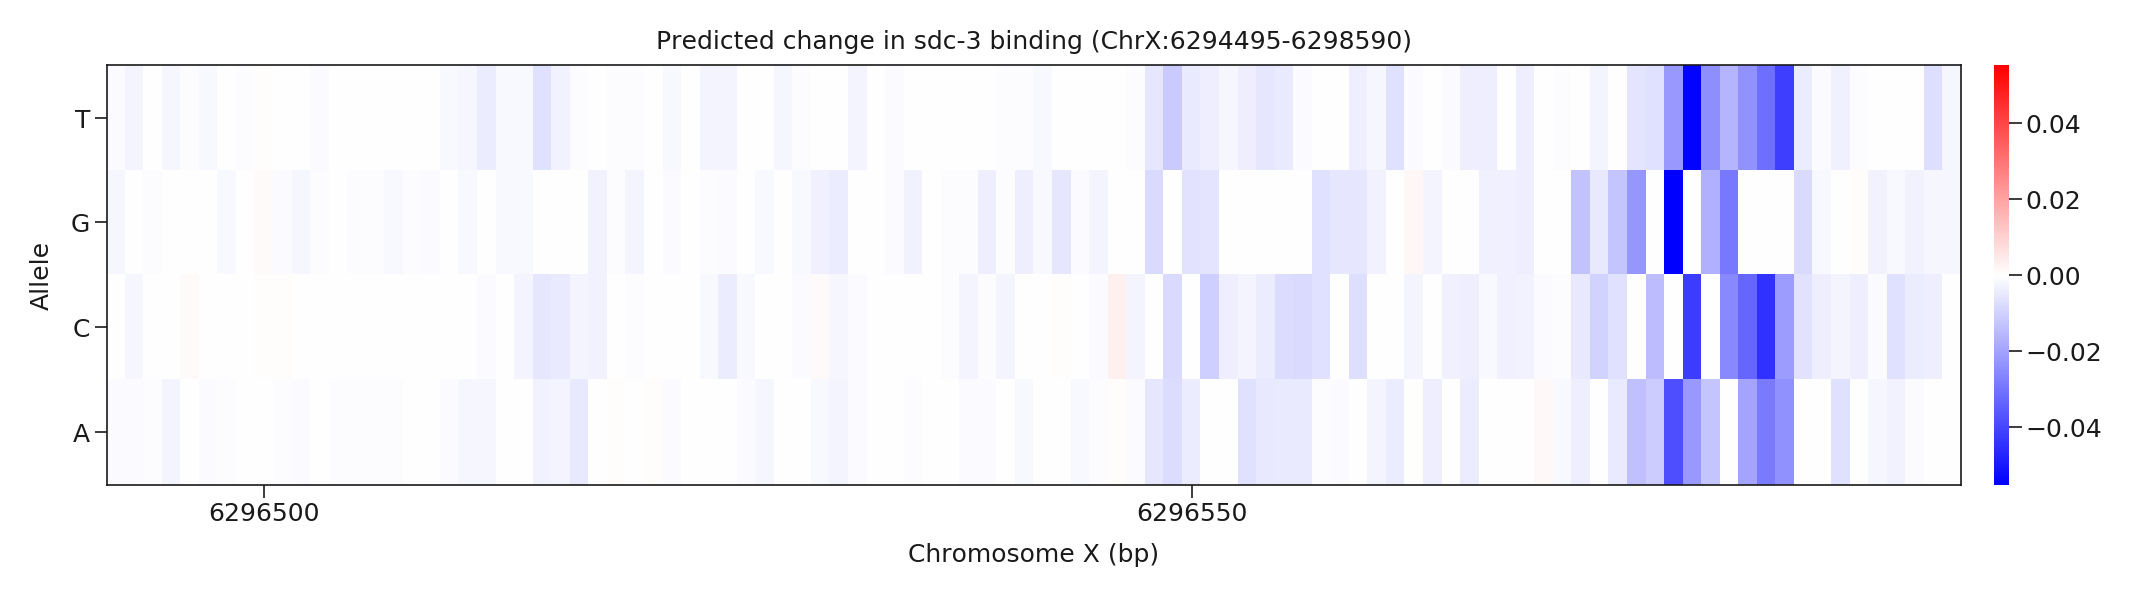

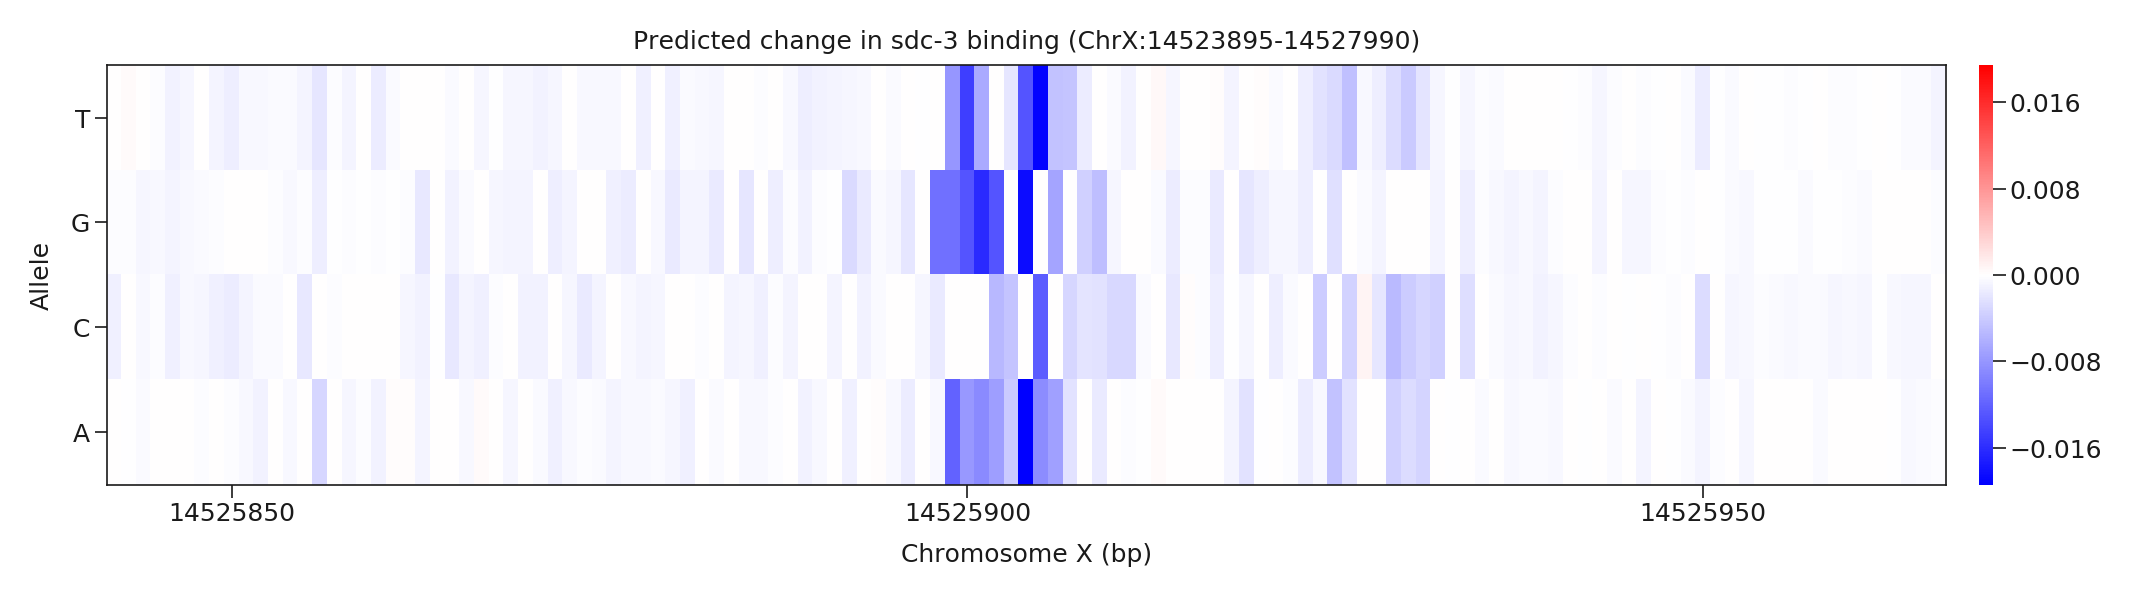

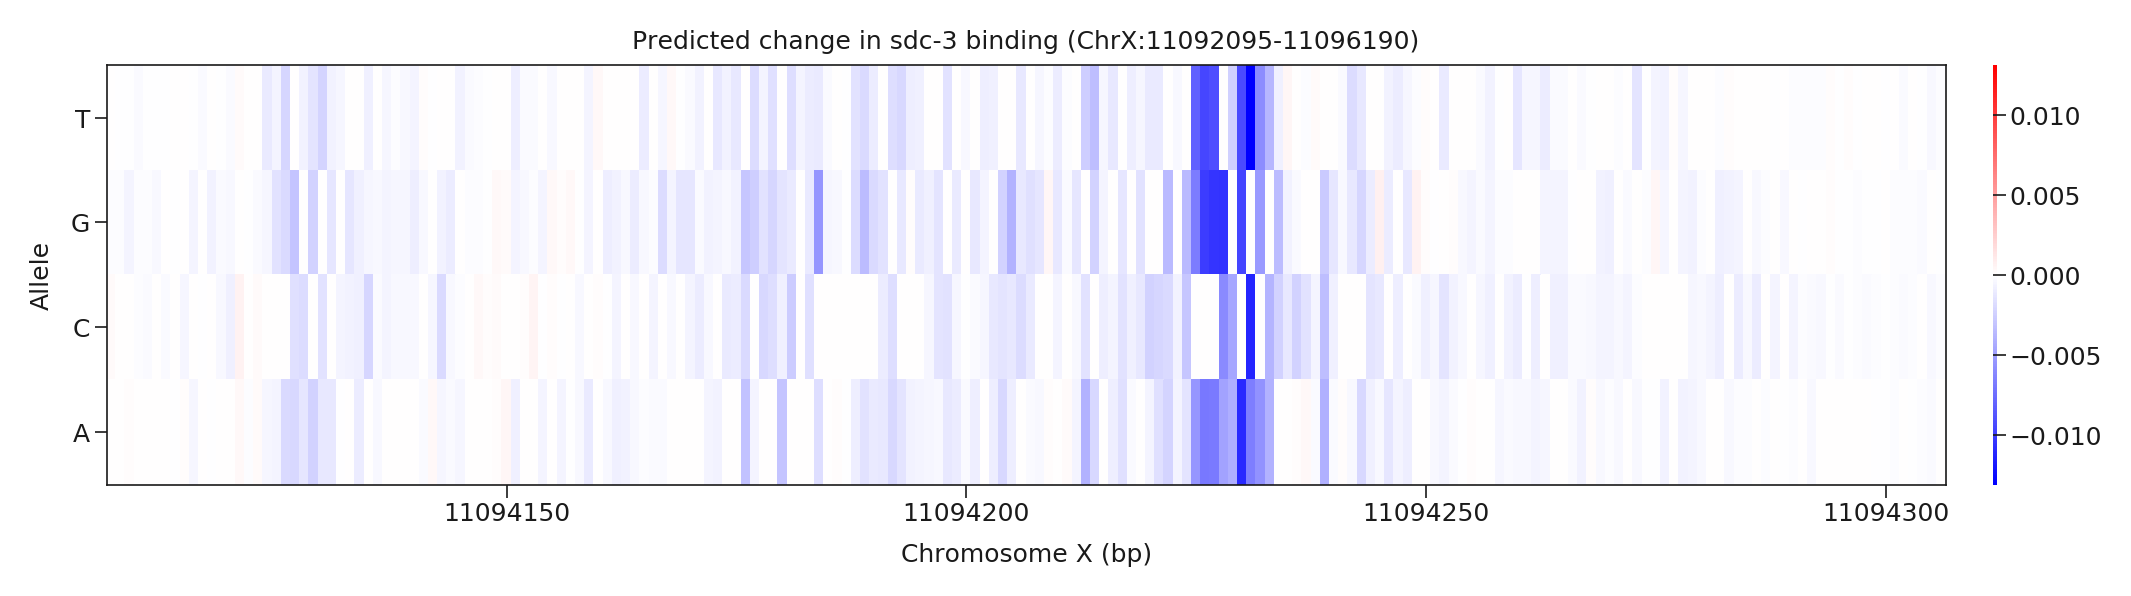

In [8]:
fmt_loci = lambda x: x[0].upper() + x[1:]
acc = "SRX2228883"
for i in range(len(top_sites)):
    # Configure plot.
    fig = plt.figure(facecolor='w', edgecolor='k', figsize=(18/2.54, 5/2.54))
    nrow = 7
    ncol = 41
    ax1 = plt.subplot2grid((nrow, ncol), (0, 0), colspan=ncol-1, rowspan=nrow)
    ax2 = plt.subplot2grid((nrow, ncol), (0, ncol-1), colspan=1, rowspan=nrow)
    d= 2047
    lhs = 2047-d
    rhs = 2047+d+1
    
    if i == 2:
        lhs = 2047- 35
        rhs = 2047 - 35 + 200
        yscale = 0.05
        fs = 3.5
    elif i == 1:
        yscale = 0.075
        fs = 5.5
        lhs = 2047 - 100
        rhs = 2047 - 100 + 125
    elif i == 0:
        lhs = 2047 - 50
        rhs = 2047 + 50
        yscale = 0.08
        fs = 6
        
    # Format data.
    df = dfs[i][["pos", "alt", acc]].pivot_table(
                values=acc, index="pos", columns="alt", fill_value=0.)
    m = df.values.copy()[lhs:rhs, :]
    mask = ref_seq_masks[i][lhs:rhs:, :]
    vext = abs(m).max()
    
    # Plot.
    selene_sdk.interpret.heatmap(m, ax=ax1, cbar=True, cmap="bwr", 
                                 vmin=-1*vext, vmax=vext, cbar_ax=ax2, 
                                 cbar_kws=dict(orientation="vertical"))
    
    # Style the axis etc.
    plt.grid(False)
    start = int(top_sites[i].split(":")[1].split("-")[0])
    end = int(top_sites[i].split(":")[1].split("-")[1])
    xticks = [x for x in range(start - (start % 50), end - (end % 50) + 50, 50) if (x >= start + lhs) and (x < start + rhs)]
    loc_ticks = numpy.array(xticks) - (start + lhs) + 0.5
    ax1.set_xticks(loc_ticks, minor=False)
    ax1.set_xticklabels([str(x) for x in xticks], minor=False, rotation=0)#, rotation=90)
    ax1.set_xlabel("Chromosome X (bp)")
    for x in ["right", "top", "bottom", "left"]:
        ax1.spines[x].set_visible(True)
    ax1.set_title("Predicted change in sdc-3 binding ({})".format(fmt_loci(top_sites[i])))
    ax1.set_ylabel("Allele")
    
    fig.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(right=0.7)
    plt.tight_layout()
    
    # Display.
    plt.show()
    plt.close(fig)

## Motif plots

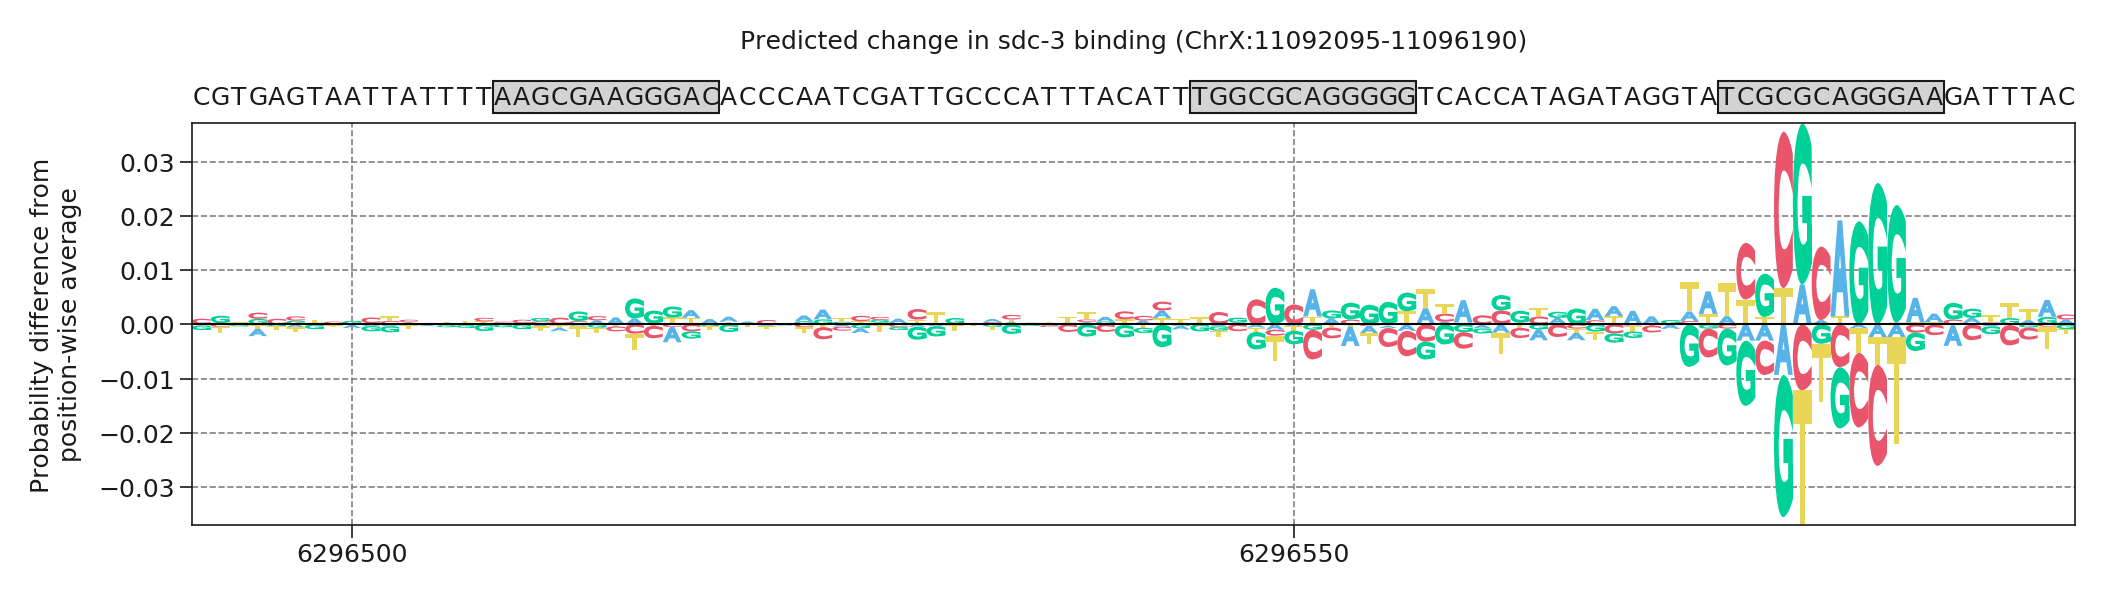

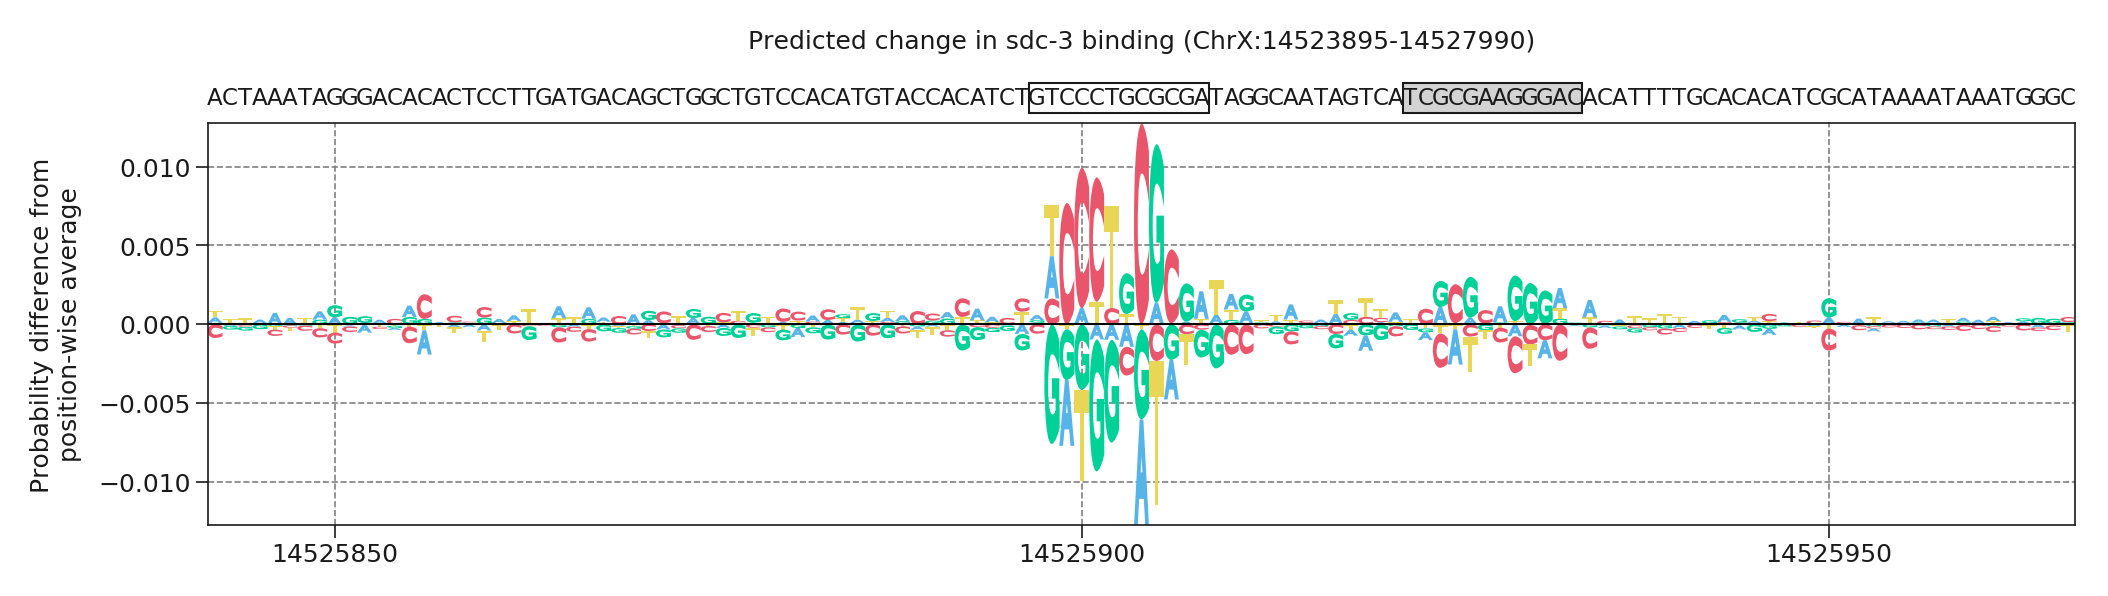

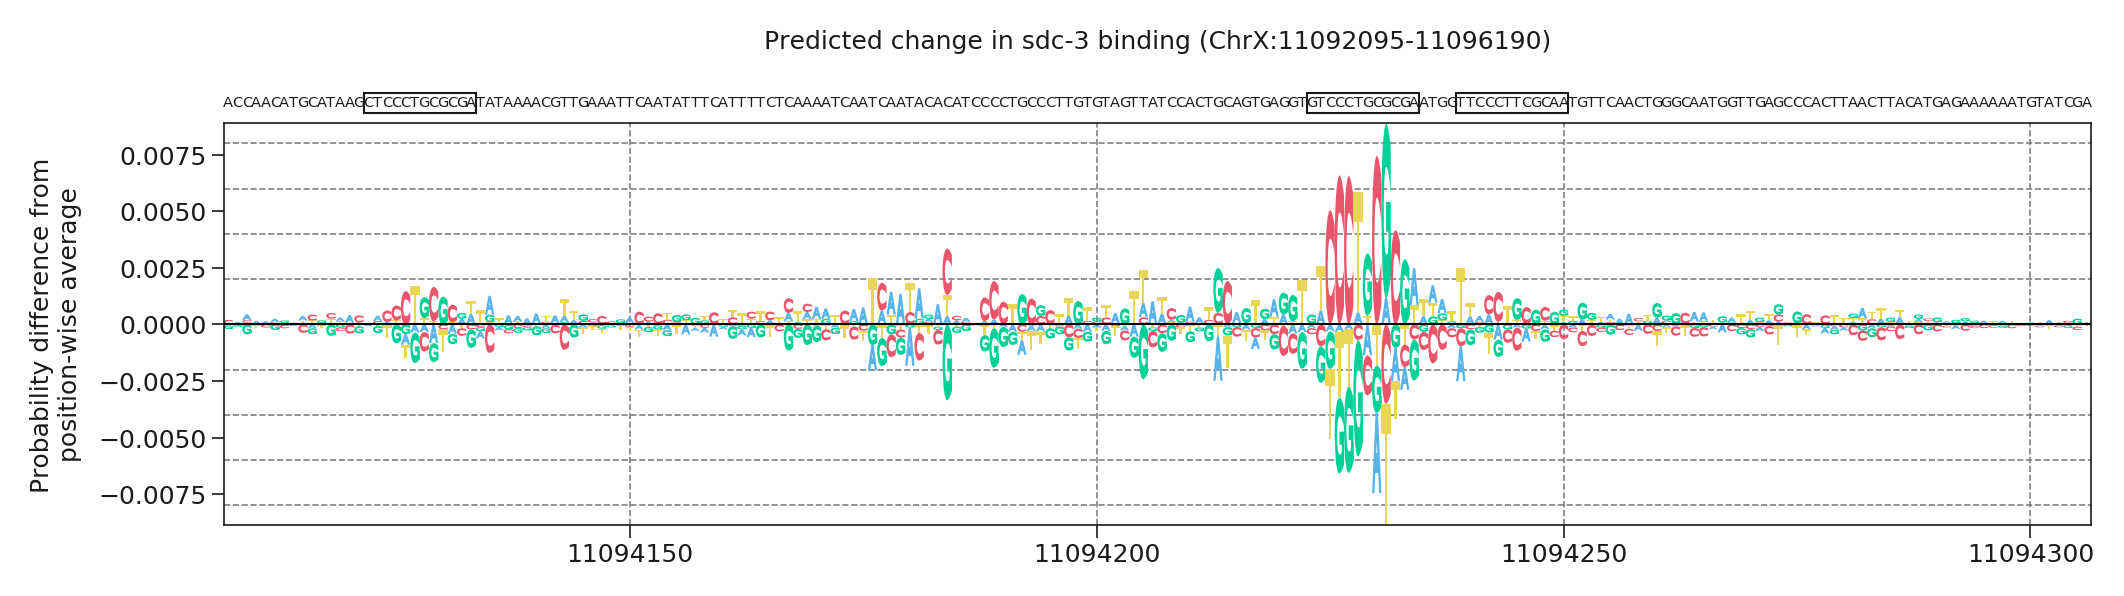

In [9]:
def modisco_normalization(m):
    if (m.shape[1] != 4):
        s = "Must have 4 nucleotides in second axis, but found {} bases there.".format(m.shape[1])
        raise ValueError(s)
    ret = copy.deepcopy(m)
    ret -= numpy.mean(ret, axis=1)[:, numpy.newaxis]
    return ret

matplotlib.rc('font', size=6)
lw = 0.4
numpy.random.seed(123)
fmt_loci = lambda x: x[0].upper() + x[1:]
acc = "SRX2228883"
for i in range(len(top_sites)):
    # Configure plot.
    fig, ax = plt.subplots(1, 1, figsize=(17.8/2.54, 5/2.54), facecolor='w', edgecolor='k')
    
    d= 2047
    lhs = 2047-d
    rhs = 2047+d+1
    
    if i == 2:
        lhs = 2047- 35
        rhs = 2047 - 35 + 200
        yscale = 0.05
        fs = 3.5
    elif i == 1:
        yscale = 0.075
        fs = 5.5
        lhs = 2047 - 100
        rhs = 2047 - 100 + 125
    elif i == 0:
        lhs = 2047 - 50
        rhs = 2047 + 50
        yscale = 0.08
        fs = 6
        
    # Format data.
    df = dfs[i][["pos", "alt", acc]].pivot_table(
                values=acc, index="pos", columns="alt", fill_value=0.)
    m = df.values.copy()[lhs:rhs, :]
    m = modisco_normalization(m)
    mask = ref_seq_masks[i][lhs:rhs:, :]
    vext = abs(m).max()
    start = int(top_sites[i].split(":")[1].split("-")[0])
    end = int(top_sites[i].split(":")[1].split("-")[1])
    
    # Plot.
    selene_sdk.interpret.sequence_logo(m, order="value", ax=ax, color_scheme=palette)
    
    # Style the axis etc.
    ax.axhline(0, color="black", zorder=1, linewidth=0.5)
    plt.grid(False)
    ax.set_title("")
    [ax.spines[x].set_visible(True) for x in ["right", "top"]]
    
    # Add secondary axis.
    ax2 = ax.twiny()
    fig.subplots_adjust(bottom=0.2) # Add space below ax.
    ax2.set_xlim(ax.get_xlim()) # Make ax2 match ax scale.
    ax2.set_ylim(ax.get_ylim())
    
    # Turn on the frame for the twin axis, but then hide all but the bottom spine.
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    for sp in ax2.spines.values():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    
     # Setup the ticks and labels.
    xticks = [x for x in range(start - (start % 50), end - (end % 50) + 50, 50) if (x >= start + lhs) and (x < start + rhs)]
    loc_ticks = numpy.array(xticks) - (start + lhs) + 0.5
    ax.set_xticks(loc_ticks, minor=False)
    ax.set_xticklabels([str(x) for x in xticks], minor=False)#, rotation=90)
    ax2.set_xticks(loc_ticks, minor=False)
    ax2.set_xticklabels([], minor=False)
    ax2.set_xlabel("")   
    
    # Set axis 1 minor ticks and sequence.
    ax2.set_xticks(numpy.arange(rhs - lhs) + 0.5, minor=True)
    ax2.set_xticklabels(list(ref_seqs[i][lhs:rhs].upper()),
                        minor=True, fontsize=fs)       

    fig.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(right=0.7)
    plt.tight_layout()
    
    # Plot motif hits.
    cur_hits = list()
    tmp = motif_hit_df.copy()
    tmp = tmp[tmp.sequence_name == top_sites[i]]
    for i in range(tmp.shape[0]):
        start = tmp.iloc[i].start
        end = tmp.iloc[i].stop + 1 
        over = min(end, rhs) - max(lhs, start) 
        if over > 0:
            cur_hits.append((start, end, max(lhs, start), min(end, rhs), tmp.iloc[i].score, tmp.iloc[i].strand, tmp.iloc[i].matched_sequence))
    for i, (_, _, show_start, show_end, score, strand, seq) in enumerate(cur_hits):
        if strand == "+":
            ax.add_patch(matplotlib.patches.Rectangle(
                    ((show_start - lhs - 1), ax.get_ylim()[1] * 1.05), width=(show_end - show_start), 
                    height=yscale*(ax.get_ylim()[1] - ax.get_ylim()[0]), 
                    edgecolor='k', facecolor='lightgrey', linewidth=0.5, fill=True, alpha=1, zorder=-1, clip_on=False))
        elif strand == "-":
            ax.add_patch(matplotlib.patches.Rectangle(
                    ((show_start - lhs - 1), ax.get_ylim()[1] * 1.05), width=(show_end - show_start), 
                    height=yscale*(ax.get_ylim()[1] - ax.get_ylim()[0]), 
                    edgecolor='k', facecolor='none', linewidth=0.5, fill=False, alpha=1, zorder=-1, clip_on=False))
        else:
            s = "Uknown strand {}".format(strand)
            raise ValueError(s)

    # Format ticks.
    ax2.tick_params(axis="x", size=0, which="both")
    for x in loc_ticks:
        if x != 0:
            ax.axvline(x, ymin=0, linestyle='--', linewidth=lw, zorder=-1, color="grey")
    for y in ax.get_yticks():
        if y != 0:
            ax.axhline(y, xmin=0, linestyle='--', linewidth=lw, zorder=-1, color="grey")
            
    ax.set_title("Predicted change in sdc-3 binding ({})".format(fmt_loci(top_sites[i])), pad=18)
    ax.set_ylabel("Probability difference from\nposition-wise average")
    plt.tight_layout()
    plt.show()